## Identifiación de Outliers mediante HBOS tomando como base la diferencia entre los puntos contiguos como criterio

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns

from funciones_OD import *

ruta = "G:/PhD/Datos SIATA/Análisis/Descriptivo/"
archivo = "DF"
datos = pd.read_csv(ruta+"test_"+archivo+"_outliers_N.csv",sep=",")
sensor = "pm25"
redondeo = 4
variables = ['pm25']#,'humedad_relativa', 'temperatura'
for sensor in variables:
    datos[sensor] = pd.Series([round(val,redondeo) for val in datos[sensor]])

Nodo: 2 Faltan: 1
Conteo: 1
[12.3303, 24.6605, 36.9908, 49.3211, 61.6513, 73.9816, 86.3119, 98.6422, 110.9724, 123.3027, 135.633, 147.9632, 160.2935, 172.6238, 184.954, 197.2843]

Ponderaciones: {12.3303: [30994, 2325.079, 1.0, 1.0], 24.6605: [395, 29.632, 0.0127, 0.0127], 36.9908: [390, 29.2567, 0.0126, 0.0126], 49.3211: [521, 39.0839, 0.0168, 0.0168], 61.6513: [594, 44.5605, 0.0192, 0.0192], 73.9816: [690, 51.7618, 0.0223, 0.0223], 86.3119: [626, 46.9607, 0.0202, 0.0202], 98.6422: [720, 54.0123, 0.0232, 0.0232], 110.9724: [695, 52.1373, 0.0224, 0.0224], 123.3027: [617, 46.2855, 0.0199, 0.0199], 135.633: [672, 50.4115, 0.0217, 0.0217], 147.9632: [620, 46.5109, 0.02, 0.02], 160.2935: [528, 39.609, 0.017, 0.017], 172.6238: [352, 26.406, 0.0114, 0.0114], 184.954: [113, 8.477, 0.0036, 0.0036], 197.2843: [10, 0.7502, 0.0003, 0.0003]}

HBOS {0: 0.0, 1: 1.8961962790440432, 2: 1.899629454882437, 3: 1.7746907182741372, 4: 1.7166987712964503, 5: 1.6516951369518393, 6: 1.6946486305533763, 7: 1.6

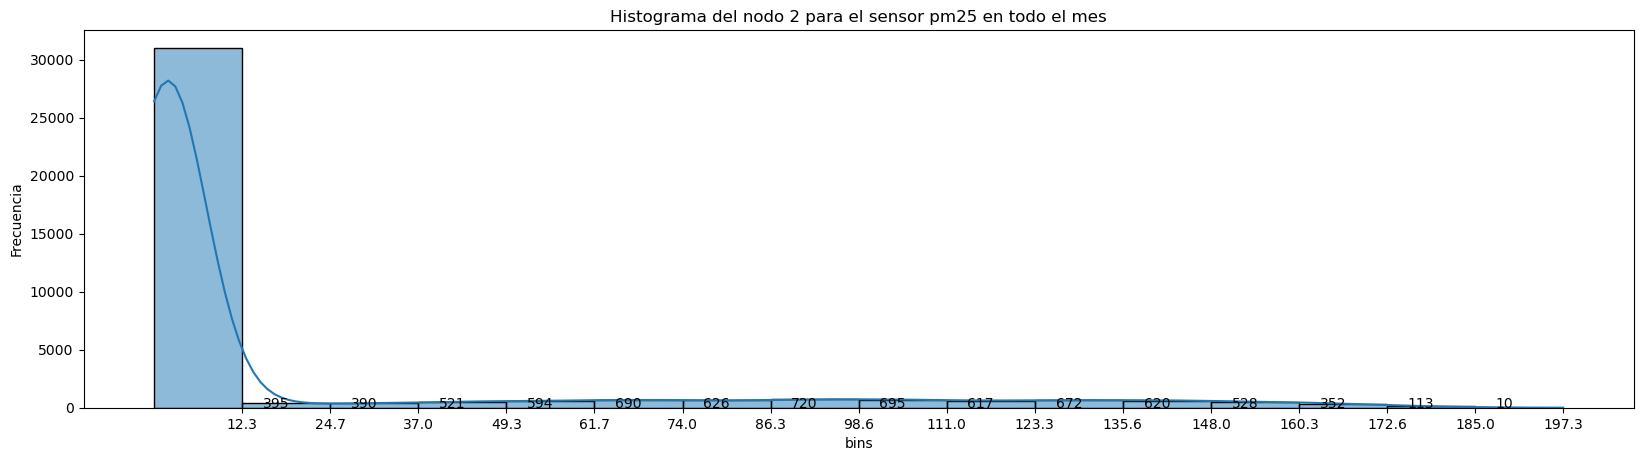

Cantidad de valores: 38537


In [2]:
# SE CALCULA TODO EL MES
pd.options.mode.chained_assignment = None  # default='warn'
datos2 = datos.copy()
datos2=datos2.assign(HBOS="N")
ident_outliers = pd.DataFrame()

#fechas = datos2.fecha.unique().tolist()
nodos = datos2.codigoSerial.unique().tolist()

now = datetime.now()
time_hbos = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)

margen_HBOS = 1
cont=1
for i in nodos:
    inicio = datetime.now()
    print("Nodo:",i, "Faltan:", len(nodos)-nodos.index(i))
    print("Conteo:",cont)
    fild = datos2.loc[datos2.loc[:,"codigoSerial"] == i]
    fild.reset_index(inplace=True, drop=True)
        
    if (len(fild)<=0):
        print("No hay datos del nodo", i)
        continue
        
    
    hbos_inicio = datetime.now()
    HBOS = {}
    diferencias(fild,variables,redondeo) # Calcula la diferencia entre dos valores contiguos
    ks,kd,n,tam_bin,bins = calcula_k(fild,variables,redondeo) # Calcula los intervalos de forma dinámica y estática y el tamaño del bin para cada uno

    for sensor in variables:
    
        # Asigna los valores a cada intervalo
        intervalos = asigna_ks(fild[sensor+'_dif'],bins) # Asignación de valores en intervalos de forma estática
        #intervalos = asigna_kd(n,fild[sensor],kd) # Asignación de valores en intervalos de forma dinpamica
            
        # Cálculo de ponderaciones de acuerdo con la frecuencia de cada intervalo (densidad de cada intervalo)
        ponderaciones = calcula_ponderaciones(intervalos,redondeo)
        print("\nPonderaciones:",ponderaciones)
            
        # Cálculo del scor HBOS para cada valor único.
        HBOS = calcula_HBOS(ponderaciones,HBOS)
        print("\nHBOS",HBOS)
    
    hbos_fin = datetime.now()
    time_hbos = time_hbos +(hbos_fin-hbos_inicio)
    

    for k in range(1,len(fild)):
        cont += 1
          
# IDENTIFICACIÓN DE OUTLIERS POR HBOS  *****************************

        # Validación de cada valor contra su respectivo score HBOS
        hbos_inicio = datetime.now()
        ponde = verifica_HBOS(HBOS,fild[variables[0]+'_dif'][k-1],bins)

        if  ponde > margen_HBOS:
            ponde = verifica_HBOS(HBOS,fild[variables[0]+'_dif'][k],bins)
            if  ponde > margen_HBOS: 
                fild.loc[k-1,"HBOS"]= "S"         
                            
        hbos_fin = datetime.now()
        time_hbos = time_hbos +(hbos_fin-hbos_inicio)
        
    fin = datetime.now()
    
    ident_outliers = pd.concat([ident_outliers,fild],ignore_index=True)
    
    print("Tiempo HBOS:", time_hbos.time())
    print("Tiempo total:", fin-inicio)
    
    
    # GRAFICA DEL HISTOGRAMA
    for sensor in variables:
        
        plt.figure(figsize=(20, 5), dpi=100)
        sns.histplot(fild[sensor+'_dif'], bins=ks, kde=True, stat='count');
    
        density, rangos, _= plt.hist(fild[sensor+'_dif'],density=True, bins=ks)
        count, _= np.histogram(fild[sensor+'_dif'],bins)
        for x,y, num in zip(bins, density, count):
            if num != 0:
                plt.text(x+2.9, y, num, fontsize=10)
                
        plt.title('Histograma del nodo ' +str(i) +' para el sensor '+sensor+' en todo el mes')
        plt.xlabel('bins')
        plt.ylabel('Frecuencia')
        plt.xticks(bins)
    
    plt.show() #dibujamos el histograma
    print("Cantidad de valores:",len(fild))    
        
########################################################################

In [3]:
ident_outliers[ident_outliers['HBOS'] == 'S']

,codigoSerial,fecha,hora,temperatura,humedad_relativa,pm25,pm25_dif,pm25_outlier,HBOS
12,2,2020-02-01,00:12:00,22.43,73.94,199.6127,158.0576,40.1096,S
13,2,2020-02-01,00:13:00,22.41,74.20,43.0006,156.6121,N,S
14,2,2020-02-01,00:14:00,22.38,74.38,139.8281,96.8275,47.337,S
24,2,2020-02-01,00:28:00,22.23,76.92,99.3747,46.2557,N,S
25,2,2020-02-01,00:29:00,22.23,76.35,71.9104,27.4643,N,S
...,...,...,...,...,...,...,...,...,...
38504,2,2020-02-29,18:28:00,25.69,62.25,177.0897,135.5346,37.2186,S
38505,2,2020-02-29,18:29:00,25.67,62.40,80.9899,96.0998,37.2186,S
38509,2,2020-02-29,18:33:00,25.58,62.66,89.4108,47.8557,41.5551,S
38512,2,2020-02-29,18:36:00,25.51,62.86,58.9010,15.9004,N,S
